In [781]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
import random
import uuid
# Pyproj Correction
pyproj.datadir.set_data_dir('/Users/shai/anaconda3/envs/geo_env/share/proj')

In [782]:
pd.options.display.max_columns=100

## Parameters

In [783]:
arnonaSqM = 5.43
rentPPM = 70
buyPPM = 20000
owners=0.65
saveTo = 'AgentsTimeSeries_Results_april12_1435.xlsx'

In [784]:
jewishPopDemo2019 = pd.read_excel('israel_population_jewish_lamas_groups_of_10_2019.xlsx')
jewishPopDemo2019.reset_index(inplace=True,drop=True)
jewishPopDemo2019.drop([0,1],inplace=True)
tot = jewishPopDemo2019['Total'].sum()
jewishPopDemo2019['ratio'] = jewishPopDemo2019['Total']/tot
mid = [ 10*i+25 for i in range(8)]
jewishPopDemo2019['middle'] = mid
ageDist = [0.2, 0.2, 0.18, 0.15, 0.14, 0.08, 0.04, 0.01]
ageMiddle = jewishPopDemo2019['middle'].values.tolist()

https://www.cbs.gov.il/he/Pages/search/TableMaps.aspx?CbsSubject=אוכלוסייה

<AxesSubplot:xlabel='Age Group 10'>

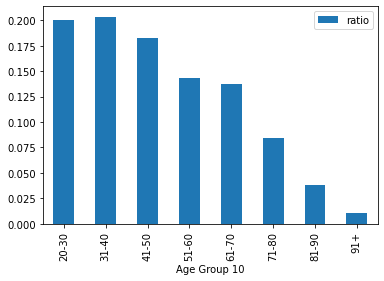

In [785]:
jewishPopDemo2019.plot.bar(x='Age Group 10',y='ratio')

In [786]:
(jewishPopDemo2019['middle'] * jewishPopDemo2019['ratio']).sum()

47.736349013718424

In [787]:
bldgs = pd.read_excel('BuildingInSimulationAndStatsApril12.xlsx') #Bldgs Data
originalAgents = pd.read_excel('OrigianlAgentsApril12_2021.xlsx') #original Agents - can be gerenated many times for sensitivity analysis
newApartments = pd.read_excel('newApartmentsDataSetApril_12_1120.xlsx') # new apartments

In [788]:
bldgs

,Unnamed: 0,BeforeBldgs,AfterBldgs,ProjType,ProjNumber,OrderA,OrderB,OrderC,min_living_till_2020,max_living_till_2020,avg_living_till_2020,Min_age_2020,Max_age_2020,Average_age_2020,StdDev_age_2020,Before_app,after_app,Above_65,Under_65,percent_above_65,Area_round_max,Area_round_mean,Area_round_min,Area_round_mode,Area_round_std,Discount_sum,High_discount_sum,Low_Discount_35_sum,No_Discount_sum,Owner_sum,Renter_sum,discount_rate_mean,bldCount,averageApartments,discount_percent,Low_discount,High_discount,No_discount,Owner_Percent
0,0,210_19,210_19_a,1,20180988,1,1,17,2.000000,35.000000,9.000000,5.000000,82.000000,45.000000,19.000000,20.000000,41.000000,8.000000,47.000000,14.545455,80.000000,63.000000,30.000000,70.000000,16.000000,5.000000,4.000000,1.000000,15.000000,12.000000,8.000000,0.150829,1,41,0.250000,0.050000,0.200000,0.750000,0.600000
1,1,210_14,210_14_a,1,20100133,2,2,18,2.000000,57.000000,19.000000,2.000000,98.000000,48.000000,24.000000,16.000000,26.000000,16.000000,46.000000,25.806452,90.000000,77.000000,70.000000,70.000000,8.000000,12.000000,8.000000,4.000000,4.000000,10.000000,6.000000,0.480824,1,26,0.750000,0.250000,0.500000,0.250000,0.625000
2,2,208_32,208_32_a,1,20180812,3,3,19,2.000000,33.000000,10.000000,5.000000,89.000000,46.000000,23.000000,17.000000,34.000000,11.000000,24.000000,31.428571,90.000000,62.000000,30.000000,50.000000,17.000000,7.000000,4.000000,3.000000,10.000000,10.000000,7.000000,0.284133,1,34,0.411765,0.176471,0.235294,0.588235,0.588235
3,3,210_3,210_3_a,1,20181092,4,4,20,2.000000,54.000000,15.000000,2.000000,99.000000,45.000000,26.000000,16.000000,30.000000,17.000000,42.000000,28.813559,80.000000,80.000000,80.000000,80.000000,0.000000,7.000000,6.000000,1.000000,9.000000,10.000000,6.000000,0.285945,1,30,0.437500,0.062500,0.375000,0.562500,0.625000
4,4,210_35,210_35_r,2,20171974,5,20,13,2.000000,43.000000,10.000000,3.000000,90.000000,46.000000,23.000000,13.000000,43.000000,14.000000,39.000000,26.415094,100.000000,66.000000,30.000000,60.000000,16.000000,5.000000,3.000000,2.000000,8.000000,8.000000,5.000000,0.243069,1,43,0.384615,0.153846,0.230769,0.615385,0.615385
5,5,210_12,210_12_a,1,20180345,6,5,21,2.000000,48.000000,17.000000,3.000000,104.000000,55.000000,20.000000,39.000000,48.000000,38.000000,60.000000,38.775510,90.000000,69.000000,40.000000,80.000000,15.000000,18.000000,10.000000,8.000000,21.000000,27.000000,12.000000,0.226707,1,48,0.461538,0.205128,0.256410,0.538462,0.692308
6,6,210_10,210_10_a,1,20140556,7,6,22,2.000000,54.000000,15.000000,2.000000,109.000000,50.000000,24.000000,16.000000,30.000000,55.000000,99.000000,35.714286,80.000000,62.000000,40.000000,70.000000,9.000000,16.000000,9.000000,6.000000,31.000000,10.000000,6.000000,0.296857,1,30,0.491803,0.196721,0.295082,0.508197,0.639344
7,7,"211_19,211_20,211_19","211_22_r,211_20_r,211_19_r",2,20170076,8,21,14,2.000000,12.000000,6.000000,2.000000,72.000000,27.000000,26.000000,4.000000,55.000000,2.000000,6.000000,25.000000,70.000000,57.000000,50.000000,50.000000,9.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,0.500000,3,36,0.500000,0.000000,0.500000,0.500000,0.500000
8,8,"224_3,220_7,220_3,210_34,210_36,220_5,210_32_2...","220_3_224_3_rr,210_30_210_32_rr,220_5_rr,220_7...",3,502-0196659,9,24,1,2.125000,48.875000,15.875000,4.375000,98.875000,47.875000,23.625000,20.250000,497.000000,18.375000,43.375000,29.204431,128.750000,77.000000,53.750000,73.750000,20.625000,8.750000,5.750000,3.000000,11.375000,10.375000,9.750000,0.258501,4,140,0.435034,0.160623,0.274411,0.564966,0.544690
9,9,215_6,215_6_r,2,20150857,10,22,15,2.000000,58.000000,14.000000,2.000000,104.000000,45.000000,26.000000,12.000000,39.000000,12.000000,30.000000,28.571429,100.000000,88.000000,60.000000,90.000000,14.000000,6.000000,3.000000,3.000000,6.000000,8.000000,4.000000,0.254921,1,39,0.500000,0.250000,0.250000,0.500000,0.666667


In [789]:
newApartments.drop(columns='Unnamed: 0',inplace=True)

## Function

In [790]:
def mortgageCal(houseValue, downPaymentPercent_range=(0.25, 0.5), years_pay=25, intrest=3.46):
    '''
        houseValue - House Value
        downPaymentPercent_range=(0.25, 0.5)
        years_pay=25
        intrest=3.46
    '''
    # Mortage Calculator
    # houseValue for example 2 Milion Shekels
    # downPayment percent the the percent that the Agent can pay of the house 25% is 500000 NIS
    # year_pay typical 25 years
    # interset typical 3.46
    dppr = downPaymentPercent_range
    downPaymentPercent = random.uniform(dppr[0], dppr[1])
    downPayment = houseValue * downPaymentPercent  # calculating the downPayment
    P = houseValue-downPayment  # Mortrage requested
    i_m = ((intrest)/100.0)/12.0  # interset percent divided by 12 months
    n_m = years_pay*12  # convert years to months
    M = (P*i_m*np.power((1+i_m), n_m))/(np.power((1+i_m), n_m)-1)
    return M

## Move all agents to new appartments add to them the itertion number this will be a template for Agents Time Series

In [791]:
AgentsTimeSeries = originalAgents.copy()
AgentsTimeSeries.drop(columns=['Unnamed: 0'],inplace=True)

In [792]:
AgentsTimeSeries['prjectType'] = 0
AgentsTimeSeries['tic'] = 0
AgentsTimeSeries['status'] = 'stay'
AgentsTimeSeries['noDiscount'] = AgentsTimeSeries['noDiscount'].fillna(0)
AgentsTimeSeriesOriginal = AgentsTimeSeries.copy()

In [793]:
bldgs.sort_values(by='OrderA',inplace=True)

In [794]:
bldgs

,Unnamed: 0,BeforeBldgs,AfterBldgs,ProjType,ProjNumber,OrderA,OrderB,OrderC,min_living_till_2020,max_living_till_2020,avg_living_till_2020,Min_age_2020,Max_age_2020,Average_age_2020,StdDev_age_2020,Before_app,after_app,Above_65,Under_65,percent_above_65,Area_round_max,Area_round_mean,Area_round_min,Area_round_mode,Area_round_std,Discount_sum,High_discount_sum,Low_Discount_35_sum,No_Discount_sum,Owner_sum,Renter_sum,discount_rate_mean,bldCount,averageApartments,discount_percent,Low_discount,High_discount,No_discount,Owner_Percent
0,0,210_19,210_19_a,1,20180988,1,1,17,2.000000,35.000000,9.000000,5.000000,82.000000,45.000000,19.000000,20.000000,41.000000,8.000000,47.000000,14.545455,80.000000,63.000000,30.000000,70.000000,16.000000,5.000000,4.000000,1.000000,15.000000,12.000000,8.000000,0.150829,1,41,0.250000,0.050000,0.200000,0.750000,0.600000
1,1,210_14,210_14_a,1,20100133,2,2,18,2.000000,57.000000,19.000000,2.000000,98.000000,48.000000,24.000000,16.000000,26.000000,16.000000,46.000000,25.806452,90.000000,77.000000,70.000000,70.000000,8.000000,12.000000,8.000000,4.000000,4.000000,10.000000,6.000000,0.480824,1,26,0.750000,0.250000,0.500000,0.250000,0.625000
2,2,208_32,208_32_a,1,20180812,3,3,19,2.000000,33.000000,10.000000,5.000000,89.000000,46.000000,23.000000,17.000000,34.000000,11.000000,24.000000,31.428571,90.000000,62.000000,30.000000,50.000000,17.000000,7.000000,4.000000,3.000000,10.000000,10.000000,7.000000,0.284133,1,34,0.411765,0.176471,0.235294,0.588235,0.588235
3,3,210_3,210_3_a,1,20181092,4,4,20,2.000000,54.000000,15.000000,2.000000,99.000000,45.000000,26.000000,16.000000,30.000000,17.000000,42.000000,28.813559,80.000000,80.000000,80.000000,80.000000,0.000000,7.000000,6.000000,1.000000,9.000000,10.000000,6.000000,0.285945,1,30,0.437500,0.062500,0.375000,0.562500,0.625000
4,4,210_35,210_35_r,2,20171974,5,20,13,2.000000,43.000000,10.000000,3.000000,90.000000,46.000000,23.000000,13.000000,43.000000,14.000000,39.000000,26.415094,100.000000,66.000000,30.000000,60.000000,16.000000,5.000000,3.000000,2.000000,8.000000,8.000000,5.000000,0.243069,1,43,0.384615,0.153846,0.230769,0.615385,0.615385
5,5,210_12,210_12_a,1,20180345,6,5,21,2.000000,48.000000,17.000000,3.000000,104.000000,55.000000,20.000000,39.000000,48.000000,38.000000,60.000000,38.775510,90.000000,69.000000,40.000000,80.000000,15.000000,18.000000,10.000000,8.000000,21.000000,27.000000,12.000000,0.226707,1,48,0.461538,0.205128,0.256410,0.538462,0.692308
6,6,210_10,210_10_a,1,20140556,7,6,22,2.000000,54.000000,15.000000,2.000000,109.000000,50.000000,24.000000,16.000000,30.000000,55.000000,99.000000,35.714286,80.000000,62.000000,40.000000,70.000000,9.000000,16.000000,9.000000,6.000000,31.000000,10.000000,6.000000,0.296857,1,30,0.491803,0.196721,0.295082,0.508197,0.639344
7,7,"211_19,211_20,211_19","211_22_r,211_20_r,211_19_r",2,20170076,8,21,14,2.000000,12.000000,6.000000,2.000000,72.000000,27.000000,26.000000,4.000000,55.000000,2.000000,6.000000,25.000000,70.000000,57.000000,50.000000,50.000000,9.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,0.500000,3,36,0.500000,0.000000,0.500000,0.500000,0.500000
8,8,"224_3,220_7,220_3,210_34,210_36,220_5,210_32_2...","220_3_224_3_rr,210_30_210_32_rr,220_5_rr,220_7...",3,502-0196659,9,24,1,2.125000,48.875000,15.875000,4.375000,98.875000,47.875000,23.625000,20.250000,497.000000,18.375000,43.375000,29.204431,128.750000,77.000000,53.750000,73.750000,20.625000,8.750000,5.750000,3.000000,11.375000,10.375000,9.750000,0.258501,4,140,0.435034,0.160623,0.274411,0.564966,0.544690
9,9,215_6,215_6_r,2,20150857,10,22,15,2.000000,58.000000,14.000000,2.000000,104.000000,45.000000,26.000000,12.000000,39.000000,12.000000,30.000000,28.571429,100.000000,88.000000,60.000000,90.000000,14.000000,6.000000,3.000000,3.000000,6.000000,8.000000,4.000000,0.254921,1,39,0.500000,0.250000,0.250000,0.500000,0.666667


In [795]:
bldgs['OrderA'].values[:8]

array([1, 2, 3, 4, 5, 6, 7, 8])

In [796]:
for tic in bldgs['OrderA'].values:
    currentProject = bldgs.query('OrderA=='+str(tic))['ProjNumber'].values[0]
    projectType = bldgs.query('OrderA=='+str(tic))['ProjType'].values[0].astype(int)
    newApartmentsSlice = newApartments.query('ProjNumber=="'+currentProject+'"').copy()
    newApartmentsSlice.reset_index(inplace=True,drop=True)
    CurrentAgents = AgentsTimeSeriesOriginal.query('ProjNumber=="'+currentProject+'"').copy().reset_index(drop=True)
    CurrentAgents.drop(columns=['bldCode','doorIndex','bldCodeDoorIndex','ProjNumber','aprtmentSize','tic','prjectType'],inplace=True)
    CurrentAgentsNewApartments = pd.concat([newApartmentsSlice,CurrentAgents],axis=1).reset_index(drop=True)
    CurrentAgentsNewApartments['tic'] = tic
    AgentsTimeSeries = pd.concat([AgentsTimeSeries,CurrentAgentsNewApartments]).reset_index(drop=True)
    #AgentsTimeSeries.reset_i

In [797]:
bldg_reference = gpd.read_file('Json/simBldgsData09042021.geojson')
bldAfter = bldg_reference[bldg_reference['status']=='Building after']

In [798]:
bldAfter.reset_index(drop=True,inplace=True)

In [799]:
bld_floor = bldAfter[['bld_addres','floors']]

In [800]:
def getBldHeight(bldCode):
    Floors = bld_floor.query(f"bld_addres=='{bldCode}'")['floors']
    return Floors.values[0].astype(int)

In [801]:
con = AgentsTimeSeries.query("tic>0").index


AgentsTimeSeries.loc[con,'Floors'] = AgentsTimeSeries.loc[con,'bldCode'].apply(getBldHeight)

# add floors from GIS :)

In [802]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,"Floors"] \
= AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,"bldCode"]\
.apply(lambda x:bld_floor.query(f"bld_addres=='{x}'")['floors'].values[0].astype(int))

In [803]:
newBldgMaintenance = pd.DataFrame({'floor_min':[0,5,9,13],'floor_max':[4,8,12,100],'cost':[250,320,400,450]})

In [804]:
newBldgMaintenance

,floor_min,floor_max,cost
0,0,4,250
1,5,8,320
2,9,12,400
3,13,100,450


In [805]:
def getConstFromFloor(floor):
    floorInt = str(int(floor))
    cost = newBldgMaintenance.query(f"floor_min<={floorInt} and floor_max>={floorInt}")['cost']
    return cost.values[0]

In [806]:
getConstFromFloor(7)

320

In [807]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,'MainCost'] = AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,'Floors'].apply(getConstFromFloor)

In [808]:
AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'cityTax'] =  AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'aprtmentSize']*arnonaSqM

In [809]:
AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'CostForStaying'] = AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'cityTax']+AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'MainCost']

## Not Null do this

In [810]:
con = ((AgentsTimeSeries['income'].notna())) & (AgentsTimeSeries['tic']>0)

In [811]:
AgentsTimeSeries.loc[con,'ratioCostForStaying'] = AgentsTimeSeries.loc[con,'CostForStaying']/AgentsTimeSeries.loc[con,'income']

In [812]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0 and rent==1.0").index,'status'] = 'leave'
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0 and rent==1.0").index,'reason_leave'] = 'Rent'

In [813]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (age>65) and (status=='stay')").index,'status'] = 'leave'
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (age>65) and (status=='leave') and ('reason_leave')!='income'").index,'reason_leave'] = 'Age'

In [814]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (ratioCostForStaying>0.08) and (status=='stay')").index,'status'] = 'leave'

In [815]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (ratioCostForStaying>0.08) and (status=='leave') and (reason_leave.isnull())").index,'reason_leave'] = 'Burden'

## not one was hrut from hosuing burden from the original tenants only Age and Rent!!!

In [816]:
AgentsTimeSeries['reason_leave'].value_counts()

Rent      246
Burden    237
Age       219
Name: reason_leave, dtype: int64

In [817]:
type(AgentsTimeSeries.loc[0,'ratioCostForStaying'])

numpy.float64

<AxesSubplot:>

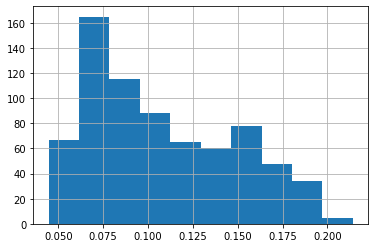

In [818]:
AgentsTimeSeries[AgentsTimeSeries['ratioCostForStaying'].notna()]['ratioCostForStaying'].hist()

In [819]:
AgentsTimeSeries['mortgage'] = 0
AgentsTimeSeries['rentPrice'] = 0

In [820]:
AgentsTimeSeries.loc[AgentsTimeSeries['prjectType']==3,'age']+=3
AgentsTimeSeries.loc[AgentsTimeSeries['prjectType'].isin([1,2]),'age']+=2

In [821]:
newAgents

,bldCode,doorIndex,bldCodeDoorIndex,ProjNumber,aprtmentSize,yearsInBldg,age,lowDiscount,highDiscount,noDiscount,income,rent,own,agentID,prjectType,tic,status,Floors,MainCost,cityTax,CostForStaying,ratioCostForStaying,reason_leave,mortgage,rentPrice,group,HouseValue,rentPrint,baseIncome
897,210_19_a,1,210_19_a_1,20180988,82,0,30,0,0,1,22673.263158,0,1,a1d41284-9b6a-11eb-88c0-acde48001122,1,1,New Comers,7.0,320.0,445.26,6814.26,0.300542,NaN,6049,0,add,1640000,0,17932.263158
898,210_19_a,2,210_19_a_2,20180988,82,0,34,0,0,1,18809.210526,0,1,a1d415f4-9b6a-11eb-88c0-acde48001122,1,1,New Comers,7.0,320.0,445.26,6825.26,0.362868,NaN,6060,0,add,1640000,0,17961.210526
900,210_19_a,4,210_19_a_4,20180988,82,0,53,0,0,1,2557.842105,1,0,a1d41676-9b6a-11eb-88c0-acde48001122,1,1,New Comers,7.0,320.0,445.26,765.26,0.299182,NaN,0,0,add,0,5740,2013.842105
901,210_19_a,5,210_19_a_5,20180988,82,0,69,0,0,1,6701.842105,1,0,a1d416b2-9b6a-11eb-88c0-acde48001122,1,1,New Comers,7.0,320.0,445.26,765.26,0.114187,NaN,0,0,add,0,5740,2013.842105
902,210_19_a,6,210_19_a_6,20180988,82,0,39,0,0,1,22501.789474,0,1,a1d416e4-9b6a-11eb-88c0-acde48001122,1,1,New Comers,7.0,320.0,445.26,6875.26,0.305543,NaN,6110,0,add,1640000,0,18092.789474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,201_75_rr,126,201_75_rr_126,502-0368860,112,0,44,0,0,1,3851.631579,1,0,a1d70246-9b6a-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,1058.16,0.274730,NaN,0,0,existing,0,7840,2784.631579
4145,201_75_rr,127,201_75_rr_127,502-0368860,112,0,40,0,0,1,26170.421053,0,1,a1d70278-9b6a-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,9329.16,0.356477,NaN,8271,0,existing,2240000,0,24550.421053
4146,201_75_rr,128,201_75_rr_128,502-0368860,112,0,56,0,0,1,27955.631579,0,1,a1d702aa-9b6a-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,9399.16,0.336217,NaN,8341,0,existing,2240000,0,24734.631579
4147,201_75_rr,129,201_75_rr_129,502-0368860,112,0,45,0,0,1,3474.631579,1,0,a1d702d2-9b6a-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,1058.16,0.304539,NaN,0,0,existing,0,7840,2784.631579


In [822]:
newAgents = AgentsTimeSeries.query("status.isnull() or status=='leave'", engine='python').copy()

In [823]:
newAgents.loc[newAgents.query("status.isnull()", engine='python').index,'group']='existing'

In [824]:
newAgents.loc[newAgents.query("status=='leave'", engine='python').index,'group']='add'

In [825]:
newAgents['yearsInBldg'] = 0

In [826]:
num = len(newAgents)
op = ageMiddle
p = ageDist

In [827]:
num

3057

In [828]:
ages = np.random.choice(op, size = num, p=p)

In [829]:
rent_own = np.random.choice(['rent','own'],size=num,p=[1-owners,owners])

In [830]:
rent_own

array(['own', 'own', 'own', ..., 'own', 'rent', 'rent'], dtype='<U4')

In [831]:
rent_filter = rent_own=='rent'
own_filter = rent_own=='own'

In [832]:
newAgents['age'] = ages

In [833]:
newAgents['age'] = newAgents['age'].apply(lambda x: np.random.randint(x-5,x+5)) # add varitation or noise ot ages

In [834]:
newAgents.loc[:,['lowDiscount','highDiscount','noDiscount']] = [0,0,1]

In [835]:
newAgents.loc[:,['rent','own']] = [0,0]

In [836]:
newAgents.loc[rent_filter,'rent'] =1
newAgents.loc[own_filter,'own'] =1

In [837]:
newAgents['agentID'] =newAgents['agentID'].apply(lambda x:uuid.uuid1()) 

In [838]:
newAgents['status'] = 'New Comers'

In [839]:
newAgents['reason_leave'] = np.nan

In [840]:
newAgents['HouseValue'] = 0
newAgents['rentPrice'] = 0
rentFilter = newAgents.query('rent==1').index
newAgents.loc[rentFilter,'rentPrice'] = rentPPM*newAgents.loc[rentFilter,'aprtmentSize'] 

ownFilter = newAgents.query('own==1').index
newAgents.loc[ownFilter,'HouseValue'] = newAgents.loc[ownFilter,'aprtmentSize'] * buyPPM
newAgents.loc[ownFilter,'mortgage'] = newAgents.loc[ownFilter,'HouseValue'].apply(lambda x: mortgageCal(houseValue=x,downPaymentPercent_range=(0.25, 0.26))).astype(int) 
newAgents['CostForStaying'] = newAgents['MainCost'] + newAgents['cityTax'] + newAgents['rentPrice'] + newAgents['mortgage']
newAgents['baseIncome'] = newAgents['CostForStaying']/0.38 # base is 38% for burden
newAgents['income'] = newAgents['baseIncome'] + newAgents['baseIncome'].apply(lambda x:np.random.randint(0,5000)).astype(int)
newAgents['ratioCostForStaying'] = (newAgents['CostForStaying']/newAgents['income'])

<AxesSubplot:>

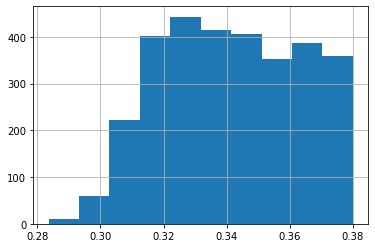

In [853]:
newAgents['ratioCostForStaying'].hist()

<AxesSubplot:>

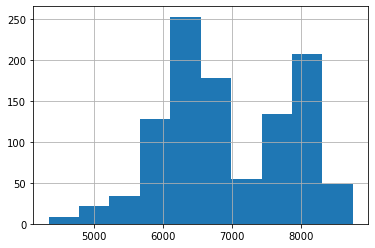

In [856]:
newAgents.loc[rentFilter,'rentPrice'].hist()

In [842]:
newAgents['ratioCostForStaying'].max()

0.38

<AxesSubplot:>

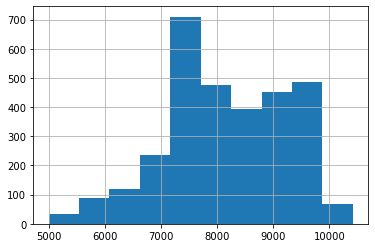

In [843]:
newAgents['CostForStaying'].hist()

In [846]:
newAgents_Merge = newAgents.query('group=="existing"').drop(columns=['HouseValue','rentPrice','baseIncome','group'])
newAgents_Add = newAgents.query('group=="add"').drop(columns=['HouseValue','rentPrice','baseIncome','group'])

In [847]:
newAgents_Merge.index

Int64Index([ 917,  918,  919,  920,  921,  922,  923,  924,  925,  926,
            ...
            4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148],
           dtype='int64', length=2355)

In [848]:
AgentsTimeSeries.loc[newAgents_Merge.index] = newAgents_Merge.copy() # Insert new Comers

In [849]:
AgentsTimeSeries = AgentsTimeSeries.append(newAgents_Add)
AgentsTimeSeries.reset_index(inplace=True, drop=True)

In [850]:
AgentsTimeSeries

,bldCode,doorIndex,bldCodeDoorIndex,ProjNumber,aprtmentSize,yearsInBldg,age,lowDiscount,highDiscount,noDiscount,income,rent,own,agentID,prjectType,tic,status,Floors,MainCost,cityTax,CostForStaying,ratioCostForStaying,reason_leave,mortgage,rentPrice
0,210_19,1,210_19_1,20180988,70,32.0,19.0,0.0,1.0,0.0,5145.000000,0.0,1.0,2a6d0426-9b6a-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,210_19,2,210_19_2,20180988,70,30.0,67.0,0.0,0.0,1.0,13088.000000,0.0,1.0,2a6d04ee-9b6a-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,210_19,3,210_19_3,20180988,70,16.0,38.0,0.0,0.0,1.0,15361.000000,0.0,1.0,2a6d052a-9b6a-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,210_19,4,210_19_4,20180988,70,6.0,16.0,0.0,1.0,0.0,5428.000000,0.0,1.0,2a6d0566-9b6a-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,210_19,5,210_19_5,20180988,70,17.0,61.0,0.0,0.0,1.0,12282.000000,1.0,0.0,2a6d058e-9b6a-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846,201_75_rr,24,201_75_rr_24,502-0368860,112,0.0,50.0,0.0,0.0,1.0,25230.000000,0.0,1.0,3cb6769e-9b83-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,9417.16,0.373252,NaN,8359,NaN
4847,201_75_rr,25,201_75_rr_25,502-0368860,112,0.0,27.0,0.0,0.0,1.0,24886.684211,0.0,1.0,3cb67748-9b83-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,9369.16,0.376473,NaN,8311,NaN
4848,201_75_rr,26,201_75_rr_26,502-0368860,112,0.0,24.0,0.0,0.0,1.0,27497.210526,1.0,0.0,3cb6777a-9b83-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,8898.16,0.323602,NaN,0,NaN
4849,201_75_rr,27,201_75_rr_27,502-0368860,112,0.0,39.0,0.0,0.0,1.0,27374.684211,0.0,1.0,3cb677ac-9b83-11eb-88c0-acde48001122,3,32,New Comers,32.0,450.0,608.16,9369.16,0.342256,NaN,8311,NaN


## Now I need to:
1. create new agents for the displaced ones (and append them)
2. crearte new agents in general and place them in the same places.


# Generating new agents (All cases)
1. Israel Age Distribution
2. Mortgage Calculator for income
3. No Discount
4. Rent/Own random if Rent Income is lower
5. Status New Comers

In [851]:
newAgents[['bldCode','bldCodeDoorIndex','status']]

,bldCode,bldCodeDoorIndex,status
897,210_19_a,210_19_a_1,New Comers
898,210_19_a,210_19_a_2,New Comers
900,210_19_a,210_19_a_4,New Comers
901,210_19_a,210_19_a_5,New Comers
902,210_19_a,210_19_a_6,New Comers
...,...,...,...
4144,201_75_rr,201_75_rr_126,New Comers
4145,201_75_rr,201_75_rr_127,New Comers
4146,201_75_rr,201_75_rr_128,New Comers
4147,201_75_rr,201_75_rr_129,New Comers


In [852]:
AgentsTimeSeries.to_excel(saveTo)